In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import datetime
import matplotlib.pyplot as plt

In [2]:
# Get data from provider
symbol = yf.Ticker('BTC-USD')
start_date = datetime.datetime.fromtimestamp(1410912000)
end_date = datetime.datetime.now()
df = symbol.history(start=start_date, end=end_date)
df = df[['Open', 'High', 'Low', 'Close']]
df.index.name = 'datetime'
df = df.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'})
df.head()

,open,high,low,close
datetime,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014


In [3]:
# Calculate features
df.ta.log_return(cumulative=False, append=True)
df.ta.bbands(close=df['LOGRET_1'], length=20, std=2, append=True)
df.head()

,open,high,low,close,LOGRET_1,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
datetime,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,-0.074643,NaN,NaN,NaN,NaN,NaN
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,-0.072402,NaN,NaN,NaN,NaN,NaN
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,0.035111,NaN,NaN,NaN,NaN,NaN
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,-0.024968,NaN,NaN,NaN,NaN,NaN


In [4]:
# Calculate signal
df["SIGNAL"] = np.where(df["LOGRET_1"] > df["BBU_20_2.0"], 1,
                       np.where(df["LOGRET_1"] < df["BBL_20_2.0"], -1, np.nan))

df["SIGNAL"] = df["SIGNAL"].ffill().bfill()
df.head()

,open,high,low,close,LOGRET_1,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,SIGNAL
datetime,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,-0.074643,NaN,NaN,NaN,NaN,NaN,-1.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,-0.072402,NaN,NaN,NaN,NaN,NaN,-1.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,0.035111,NaN,NaN,NaN,NaN,NaN,-1.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,-0.024968,NaN,NaN,NaN,NaN,NaN,-1.0


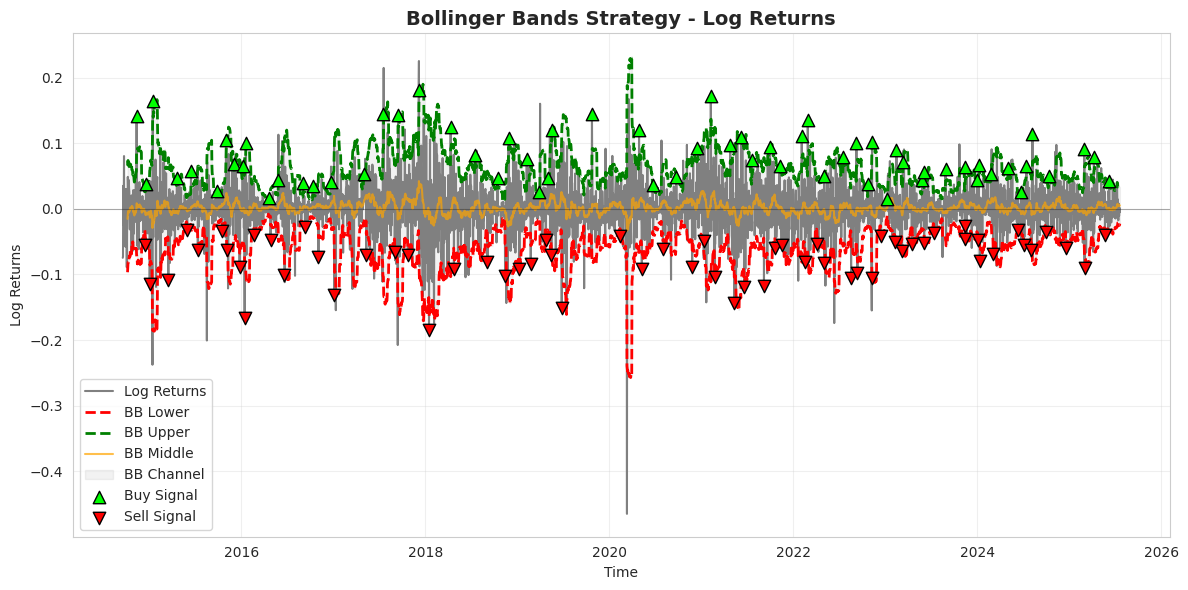

In [5]:
# Versión súper simple y bonita
plt.figure(figsize=(12, 6))

# Plotear con colores bonitos
plt.plot(df['LOGRET_1'], color='gray', linewidth=1.5, label='Log Returns')
plt.plot(df['BBL_20_2.0'], color='red', linestyle='--', linewidth=2, label='BB Lower')
plt.plot(df['BBU_20_2.0'], color='green', linestyle='--', linewidth=2, label='BB Upper')
plt.plot(df['BBM_20_2.0'], color='orange', linewidth=1.5, alpha=0.7, label='BB Middle')

# Sombrear área entre bandas
plt.fill_between(df.index, df['BBL_20_2.0'], df['BBU_20_2.0'],
                 alpha=0.1, color='gray', label='BB Channel')

# Detectar CAMBIOS de señal (no todas las señales)
signal_changes = df['SIGNAL'] != df['SIGNAL'].shift(1)
buy_changes = signal_changes & (df['SIGNAL'] == 1)
sell_changes = signal_changes & (df['SIGNAL'] == -1)

plt.scatter(df.index[buy_changes], df['LOGRET_1'][buy_changes],
           color='lime', marker='^', s=80, label='Buy Signal', zorder=5, edgecolors='black')
plt.scatter(df.index[sell_changes], df['LOGRET_1'][sell_changes],
           color='red', marker='v', s=80, label='Sell Signal', zorder=5, edgecolors='black')

# Línea en cero
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)

# Estilo
plt.title('Bollinger Bands Strategy - Log Returns', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
class Order:
    datetime : datetime.datetime
    symbol : str
    side : str
    quantity : int
    price : float
    commission : float
    def __init__(self, datetime, symbol, side, quantity, price, commission):
        self.datetime = datetime
        self.symbol = symbol
        self.side = side
        self.quantity = quantity
        self.price = price
        self.commission = commission

class Trade:
    opening_order : Order
    closing_order : Order
    def __init__(self, opening_order, closing_order):
        self.opening_order = opening_order
        self.closing_order = closing_order

In [8]:
class BacktestingSettings:
    symbol : str
    commission_rate : float
    start_date : datetime.datetime
    end_date : datetime.datetime
    take_profit : float
    stop_loss : float
    def __init__(
            self,
            symbol,
            start_date,
            end_date,
            take_profit,
            stop_loss,
            commission_rate,
            starting_balance,
            pos_size,
            unit_size
    ):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.take_profit = take_profit
        self.stop_loss = stop_loss
        self.commission_rate = commission_rate
        self.starting_balance = starting_balance
        self.pos_size = pos_size
        self.unit_size = unit_size

class Backtester:
    def __init__(self, backtesting_settings : BacktestingSettings):
        self.backtesting_settings = backtesting_settings
        self.orders = []
        self.trades = []

    def get_orders_df(self):
        if not self.orders:
            return pd.DataFrame()
        orders_data = []
        for order in self.orders:
            orders_data.append({
                'datetime': order.datetime,
                'symbol': order.symbol,
                'side': order.side,
                'quantity': order.quantity,
                'price': order.price,
                'commission': order.commission,
            })
        df = pd.DataFrame(orders_data)
        df.set_index('datetime', inplace=True)
        return df

    def get_trades_df(self):
        if not self.trades:
            return pd.DataFrame()
        trades_data = []
        for trade in self.trades:
            opening = trade.opening_order
            closing = trade.closing_order

            pnl = (closing.price - opening.price) / opening.quantity
            total_commission = opening.commission + closing.commission
            net_pnl = pnl - total_commission
            pct_return = (closing.price - opening.price) / opening.price * 100

            trades_data.append({
                'open_datetime': opening.datetime,
                'close_datetime': closing.datetime,
                'symbol': opening.symbol,
                'quantity': opening.quantity,
                'open_price': opening.price,
                'close_price': closing.price,
                'gross_pnl' : pnl,
                'total_commission': total_commission,
                'net_pnl': net_pnl,
                'pct_return': pct_return,
                'duration': closing.datetime - opening.datetime,
            })

        df = pd.DataFrame(trades_data)
        if not df.empty:
            df.set_index('open_datetime', inplace=True)
        return df

    def backtest(self, df):
        last_signal = 0
        last_order = None

        for i in range(1, len(df)):
            datetime = df.index[i]
            open = df.iloc[i]['open']
            high = df.iloc[i]['high']
            low = df.iloc[i]['low']
            close = df.iloc[i]['close']
            signal = df.iloc[i - 1]['SIGNAL']
            last_order = self.orders[-1] if self.orders else None

            if last_signal != signal:
                last_signal = signal

            if last_signal == 1:
                if not last_order or last_order.side == 'SELL':

                    order = Order(
                        datetime=datetime,
                        symbol=self.backtesting_settings.symbol,
                        side='BUY',
                        quantity=self.backtesting_settings.pos_size/open,
                        price=open,
                        commission=self.backtesting_settings.commission_rate * self.backtesting_settings.pos_size
                    ) # open a trade
                    self.orders.append(order)

                    take_profit_price = open * (1 + self.backtesting_settings.take_profit)
                    stop_loss_price = open * (1 - self.backtesting_settings.stop_loss)

            elif last_signal == -1:
                if last_order and last_order.side == 'BUY':
                    order = Order(
                        datetime=datetime,
                        symbol=self.backtesting_settings.symbol,
                        side='SELL',
                        quantity=last_order.quantity,
                        price=open,
                        commission=self.backtesting_settings.commission_rate * self.backtesting_settings.pos_size
                    ) # close a trade
                    self.orders.append(order)
                    self.trades.append(Trade(last_order, order))

                    take_profit_price = open * (1 + self.backtesting_settings.take_profit)
                    stop_loss_price = open * (1 - self.backtesting_settings.stop_loss)

            if last_order and last_order.side == 'BUY' and low < stop_loss_price:
                order = Order(
                    datetime=datetime,
                    symbol=self.backtesting_settings.symbol,
                    side='SELL',
                    quantity=last_order.quantity,
                    price=stop_loss_price,
                    commission=self.backtesting_settings.commission_rate * self.backtesting_settings.pos_size
                )
                self.orders.append(order)
                self.trades.append(Trade(last_order, order))


            elif last_order and last_order.side == "BUY" and high > take_profit_price:
                order = Order(
                    datetime=datetime,
                    symbol=self.backtesting_settings.symbol,
                    side='SELL',
                    quantity=last_order.quantity,
                    price=take_profit_price,
                    commission=self.backtesting_settings.commission_rate * self.backtesting_settings.pos_size
                )
                self.orders.append(order)
                self.trades.append(Trade(last_order, order))

        if last_order and last_order.side == 'BUY':
            order = Order(
                datetime=datetime,
                symbol=self.backtesting_settings.symbol,
                side='SELL',
                quantity=last_order.quantity,
                price=close,
                commission=self.backtesting_settings.commission_rate * self.backtesting_settings.pos_size
            )
            self.orders.append(order)
            self.trades.append(Trade(last_order, order))


In [9]:
settings = BacktestingSettings(
    symbol='BTC-USD',
    start_date=datetime.datetime.fromtimestamp(1410912000),
    end_date=datetime.datetime.now(),
    take_profit=50/100,
    stop_loss=1/100,
    commission_rate=0.75/100,
    starting_balance=10000,
    pos_size=500,
    unit_size="SET" # PER OR SET
)

backtester = Backtester(settings)

backtester.backtest(df)

In [10]:
orders_df = backtester.get_orders_df()
orders_df

,symbol,side,quantity,price,commission
datetime,,,,,
2014-11-13 00:00:00+00:00,BTC-USD,BUY,1.170212,427.273010,3.75
2014-11-14 00:00:00+00:00,BTC-USD,SELL,1.170212,423.000280,3.75
2014-11-15 00:00:00+00:00,BTC-USD,BUY,1.251095,399.649994,3.75
2014-11-16 00:00:00+00:00,BTC-USD,SELL,1.251095,395.653494,3.75
2014-11-17 00:00:00+00:00,BTC-USD,BUY,1.287502,388.348999,3.75
...,...,...,...,...,...
2025-06-20 00:00:00+00:00,BTC-USD,SELL,0.004780,103556.049609,3.75
2025-06-21 00:00:00+00:00,BTC-USD,BUY,0.004840,103315.078125,3.75
2025-06-22 00:00:00+00:00,BTC-USD,SELL,0.004840,102281.927344,3.75


In [11]:
trades_df = backtester.get_trades_df()
trades_df

,close_datetime,symbol,quantity,open_price,close_price,gross_pnl,total_commission,net_pnl,pct_return,duration
open_datetime,,,,,,,,,,
2014-11-13 00:00:00+00:00,2014-11-14 00:00:00+00:00,BTC-USD,1.170212,427.273010,423.000280,-3.651245e+00,7.5,-1.115124e+01,-1.000000,1 days
2014-11-15 00:00:00+00:00,2014-11-16 00:00:00+00:00,BTC-USD,1.251095,399.649994,395.653494,-3.194402e+00,7.5,-1.069440e+01,-1.000000,1 days
2014-11-17 00:00:00+00:00,2014-11-18 00:00:00+00:00,BTC-USD,1.287502,388.348999,384.465509,-3.016299e+00,7.5,-1.051630e+01,-1.000000,1 days
2014-11-19 00:00:00+00:00,2014-11-20 00:00:00+00:00,BTC-USD,1.337270,373.895996,370.157036,-2.795964e+00,7.5,-1.029596e+01,-1.000000,1 days
2014-11-21 00:00:00+00:00,2014-11-22 00:00:00+00:00,BTC-USD,1.397120,357.878998,354.300208,-2.561548e+00,7.5,-1.006155e+01,-1.000000,1 days
...,...,...,...,...,...,...,...,...,...,...
2025-06-14 00:00:00+00:00,2025-06-15 00:00:00+00:00,BTC-USD,0.004712,106108.085938,105047.005078,-2.251785e+05,7.5,-2.251860e+05,-1.000000,1 days
2025-06-16 00:00:00+00:00,2025-06-17 00:00:00+00:00,BTC-USD,0.004737,105555.593750,104500.037812,-2.228397e+05,7.5,-2.228472e+05,-1.000000,1 days
2025-06-18 00:00:00+00:00,2025-06-20 00:00:00+00:00,BTC-USD,0.004780,104602.070312,103556.049609,-2.188319e+05,7.5,-2.188394e+05,-1.000000,2 days


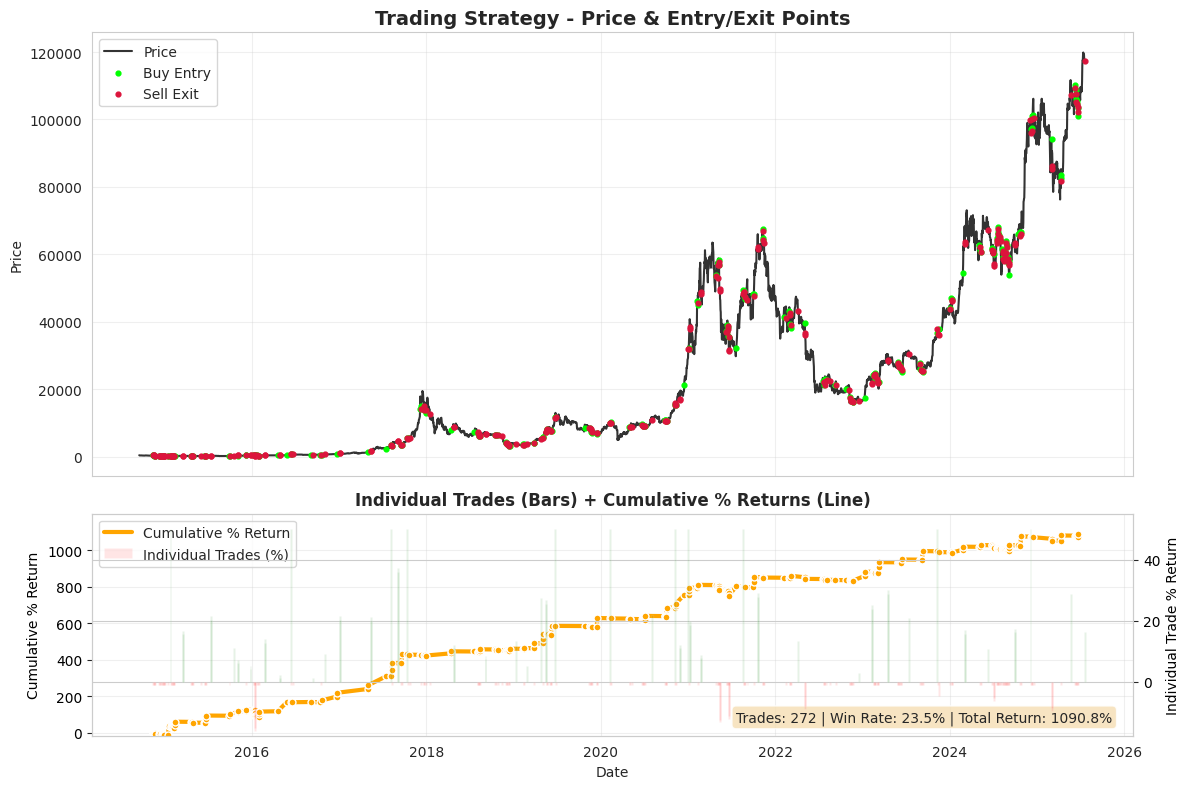

In [12]:
# Get the DataFrames
orders_df = backtester.get_orders_df()
trades_df = backtester.get_trades_df()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8),
                               gridspec_kw={'height_ratios': [2, 1]},
                               sharex=True)

# ========== TOP PLOT: PRICE + ENTRY/EXIT POINTS ==========
# Plot price (close)
ax1.plot(df.index, df['close'], color='black', linewidth=1.5, label='Price', alpha=0.8)

# Separate buy and sell orders
buy_orders = orders_df[orders_df['side'] == 'BUY']
sell_orders = orders_df[orders_df['side'] == 'SELL']

# Mark entries (BUY)
if not buy_orders.empty:
    ax1.scatter(buy_orders.index, buy_orders['price'],
               color='lime', marker='o', s=12,
               label='Buy Entry', zorder=5, edgecolors='lime', linewidth=1)

# Mark exits (SELL)
if not sell_orders.empty:
    ax1.scatter(sell_orders.index, sell_orders['price'],
               color='crimson', marker='o', s=12,
               label='Sell Exit', zorder=5, edgecolors='crimson', linewidth=1)

ax1.set_title('Trading Strategy - Price & Entry/Exit Points', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# ========== BOTTOM PLOT: % RETURNS WITH BARS ==========
if not trades_df.empty:
    # Cumulative % returns line (left axis)
    cumulative_pct = trades_df['pct_return'].cumsum()
    line1 = ax2.plot(cumulative_pct.index, cumulative_pct.values,
                     color='orange', linewidth=3, label='Cumulative % Return', zorder=10)

    # Mark points on cumulative line
    ax2.scatter(cumulative_pct.index, cumulative_pct.values,
               color='orange', s=25, zorder=11, edgecolors='white', linewidth=1)

    ax2.set_ylabel('Cumulative % Return', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Create second Y axis for individual bars
    ax2_twin = ax2.twinx()
    bar_colors = ['green' if pct > 0 else 'red' for pct in trades_df['pct_return']]
    bars = ax2_twin.bar(trades_df['close_datetime'], trades_df['pct_return'],
                       color=bar_colors, alpha=0.1, width=8,
                       label='Individual Trades (%)')

    ax2_twin.set_ylabel('Individual Trade % Return', color='black')
    ax2_twin.tick_params(axis='y', labelcolor='black')
    
    # ========== ALIGN ZEROS WITH MINIMAL NEGATIVE SPACE ==========
    # Get actual data ranges
    cum_min = cumulative_pct.min()
    cum_max = cumulative_pct.max()
    
    ind_min = trades_df['pct_return'].min()
    ind_max = trades_df['pct_return'].max()
    
    # Calculate limits - minimal negative space, full positive space
    margin = 1.1
    
    # Lower limit: only show the worst loss (or 0 if no losses)
    cum_lower = min(0, cum_min * margin) if cum_min < 0 else 0
    ind_lower = min(0, ind_min * margin) if ind_min < 0 else 0
    
    # Upper limit: show all gains with margin
    cum_upper = max(cum_max * margin, abs(cum_lower) * 0.1)  # Ensure some positive space
    ind_upper = max(ind_max * margin, abs(ind_lower) * 0.1)  # Ensure some positive space
    
    # Set aligned limits
    ax2.set_ylim(cum_lower, cum_upper)
    ax2_twin.set_ylim(ind_lower, ind_upper)
    
    # Zero reference line
    # ax2.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=1)

    # Combine legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Calculate basic statistics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pct_return'] > 0])
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    total_return = trades_df['pct_return'].sum()

    # Show statistics on chart (bottom right)
    stats_text = f"Trades: {total_trades} | Win Rate: {win_rate:.1f}% | Total Return: {total_return:.1f}%"
    ax2.text(0.98, 0.05, stats_text, transform=ax2.transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='bottom', horizontalalignment='right', fontsize=10)

    ax2.set_title('Individual Trades (Bars) + Cumulative % Returns (Line)', fontsize=12, fontweight='bold')

else:
    ax2.text(0.5, 0.5, 'No completed trades to display',
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)
    ax2.set_title('Strategy Performance - No Data', fontsize=12)

ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# Parameter optimization with heatmap
import seaborn as sns
from itertools import product

# Define parameter ranges
stop_loss_range = np.arange(0.01, 0.21, 0.01)  # 1% to 20% in 1% steps
take_profit_range = np.arange(0.05, 0.51, 0.05)  # 5% to 50% in 5% steps

print(f"Testing {len(stop_loss_range)} stop loss values: {stop_loss_range[0]:.0%} to {stop_loss_range[-1]:.0%}")
print(f"Testing {len(take_profit_range)} take profit values: {take_profit_range[0]:.0%} to {take_profit_range[-1]:.0%}")
print(f"Total combinations: {len(stop_loss_range) * len(take_profit_range)}")

Testing 20 stop loss values: 1% to 20%
Testing 10 take profit values: 5% to 50%
Total combinations: 200


In [14]:
def run_backtest_optimization(df, stop_loss_range, take_profit_range):
    """
    Run backtest for all combinations of stop loss and take profit values
    Returns a matrix with performance metrics
    """
    results = []
    total_combinations = len(stop_loss_range) * len(take_profit_range)
    current_iteration = 0
    
    print("Starting optimization...")
    
    for sl in stop_loss_range:
        for tp in take_profit_range:
            current_iteration += 1
            
            # Create settings for this combination
            settings = BacktestingSettings(
                symbol='BTC-USD',
                start_date=datetime.datetime.fromtimestamp(1410912000),
                end_date=datetime.datetime.now(),
                take_profit=tp,
                stop_loss=sl,
                commission_rate=0.75/100,
                starting_balance=10000,
                pos_size=500,
                unit_size="SET"
            )
            
            # Create new backtester instance
            backtester = Backtester(settings)
            
            # Run backtest
            backtester.backtest(df.copy())
            
            # Get results
            trades_df = backtester.get_trades_df()
            
            if not trades_df.empty:
                total_return = trades_df['pct_return'].sum()
                win_rate = (trades_df['pct_return'] > 0).sum() / len(trades_df) * 100
                avg_return = trades_df['pct_return'].mean()
                total_trades = len(trades_df)
                sharpe_ratio = trades_df['pct_return'].mean() / trades_df['pct_return'].std() if trades_df['pct_return'].std() > 0 else 0
            else:
                total_return = 0
                win_rate = 0
                avg_return = 0
                total_trades = 0
                sharpe_ratio = 0
            
            results.append({
                'stop_loss': sl,
                'take_profit': tp,
                'total_return': total_return,
                'win_rate': win_rate,
                'avg_return': avg_return,
                'total_trades': total_trades,
                'sharpe_ratio': sharpe_ratio
            })
            
            # Progress indicator
            if current_iteration % 20 == 0 or current_iteration == total_combinations:
                progress = (current_iteration / total_combinations) * 100
                print(f"Progress: {progress:.1f}% ({current_iteration}/{total_combinations})")
    
    return pd.DataFrame(results)

# Run the optimization
optimization_results = run_backtest_optimization(df, stop_loss_range, take_profit_range)

Starting optimization...
Progress: 10.0% (20/200)
Progress: 20.0% (40/200)
Progress: 30.0% (60/200)
Progress: 40.0% (80/200)
Progress: 50.0% (100/200)
Progress: 60.0% (120/200)
Progress: 70.0% (140/200)
Progress: 80.0% (160/200)
Progress: 90.0% (180/200)
Progress: 100.0% (200/200)


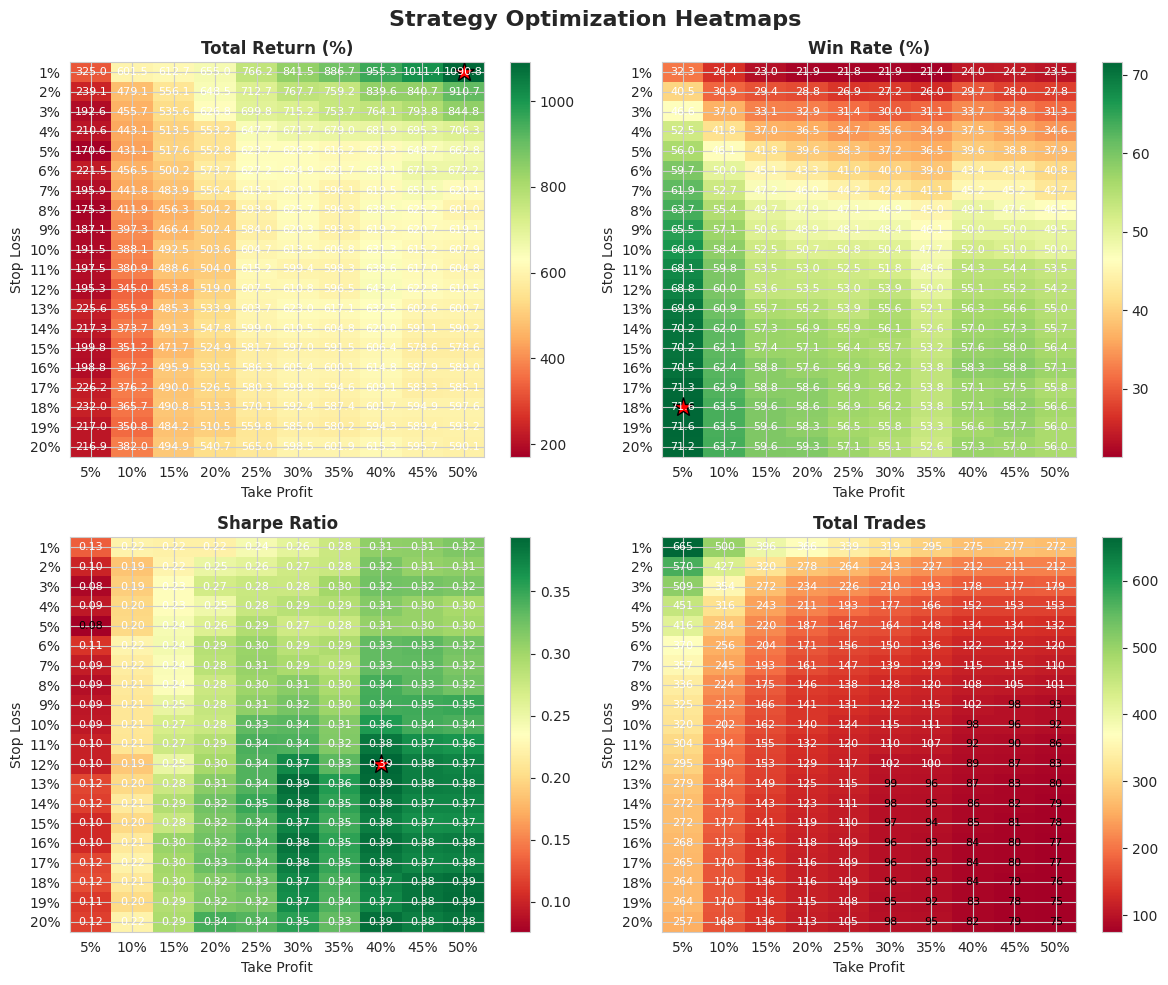

In [15]:
def create_heatmaps(results_df):
    """
    Create multiple heatmaps for different performance metrics
    """
    # Create pivot tables for each metric
    metrics = ['total_return', 'win_rate', 'sharpe_ratio', 'total_trades']
    metric_names = ['Total Return (%)', 'Win Rate (%)', 'Sharpe Ratio', 'Total Trades']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        # Create pivot table
        pivot_table = results_df.pivot_table(
            values=metric, 
            index='stop_loss', 
            columns='take_profit', 
            aggfunc='mean'
        )
        
        # Create heatmap
        im = axes[i].imshow(pivot_table.values, cmap='RdYlGn', aspect='auto')
        
        # Set ticks and labels
        axes[i].set_xticks(range(len(pivot_table.columns)))
        axes[i].set_yticks(range(len(pivot_table.index)))
        axes[i].set_xticklabels([f'{x:.0%}' for x in pivot_table.columns])
        axes[i].set_yticklabels([f'{y:.0%}' for y in pivot_table.index])
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i])
        
        # Add text annotations
        for row in range(len(pivot_table.index)):
            for col in range(len(pivot_table.columns)):
                value = pivot_table.iloc[row, col]
                if not np.isnan(value):
                    if metric == 'total_return':
                        text = f'{value:.1f}'
                    elif metric == 'win_rate':
                        text = f'{value:.1f}'
                    elif metric == 'sharpe_ratio':
                        text = f'{value:.2f}'
                    else:
                        text = f'{int(value)}'
                    axes[i].text(col, row, text, ha='center', va='center', 
                               fontsize=8, color='black' if abs(value) < pivot_table.values.std() else 'white')
        
        axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Take Profit')
        axes[i].set_ylabel('Stop Loss')
        
        # Find and mark the best combination for this metric
        if metric in ['total_return', 'win_rate', 'sharpe_ratio']:
            best_idx = pivot_table.values.argmax()
            best_row, best_col = np.unravel_index(best_idx, pivot_table.shape)
            axes[i].plot(best_col, best_row, 'r*', markersize=15, markeredgecolor='black', markeredgewidth=1)
    
    plt.suptitle('Strategy Optimization Heatmaps', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return pivot_table

# Create the heatmaps
pivot_table = create_heatmaps(optimization_results)

In [16]:
# Find and display the best combinations for each metric
def find_optimal_parameters(results_df):
    """
    Find the optimal stop loss and take profit combinations for different metrics
    """
    print("=" * 60)
    print("OPTIMAL PARAMETER COMBINATIONS")
    print("=" * 60)
    
    metrics = {
        'total_return': 'Total Return (%)',
        'win_rate': 'Win Rate (%)', 
        'sharpe_ratio': 'Sharpe Ratio'
    }
    
    best_combinations = {}
    
    for metric, name in metrics.items():
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_combinations[metric] = {
            'stop_loss': best_row['stop_loss'],
            'take_profit': best_row['take_profit'],
            'value': best_row[metric]
        }
        
        print(f"\n{name}:")
        print(f"  Stop Loss: {best_row['stop_loss']:.1%}")
        print(f"  Take Profit: {best_row['take_profit']:.1%}")
        print(f"  {name}: {best_row[metric]:.2f}")
        print(f"  Total Trades: {int(best_row['total_trades'])}")
        print(f"  Win Rate: {best_row['win_rate']:.1f}%")

    
    return best_combinations, best_balanced

# Find optimal parameters
best_combos, best_balanced = find_optimal_parameters(optimization_results)

# Display summary statistics
print(f"\n{'='*60}")
print("OPTIMIZATION SUMMARY")
print("="*60)
print(f"Total combinations tested: {len(optimization_results)}")
print(f"Stop Loss range: {stop_loss_range[0]:.0%} - {stop_loss_range[-1]:.0%}")
print(f"Take Profit range: {take_profit_range[0]:.0%} - {take_profit_range[-1]:.0%}")
print(f"Best Total Return: {optimization_results['total_return'].max():.1f}%")
print(f"Best Win Rate: {optimization_results['win_rate'].max():.1f}%")
print(f"Best Sharpe Ratio: {optimization_results['sharpe_ratio'].max():.2f}")

OPTIMAL PARAMETER COMBINATIONS

Total Return (%):
  Stop Loss: 1.0%
  Take Profit: 50.0%
  Total Return (%): 1090.80
  Total Trades: 272
  Win Rate: 23.5%

Win Rate (%):
  Stop Loss: 18.0%
  Take Profit: 5.0%
  Win Rate (%): 71.59
  Total Trades: 264
  Win Rate: 71.6%

Sharpe Ratio:
  Stop Loss: 12.0%
  Take Profit: 40.0%
  Sharpe Ratio: 0.39
  Total Trades: 89
  Win Rate: 55.1%


NameError: name 'best_balanced' is not defined